## 1. Installation and Setup

In [2]:
#!pip install datasets

In [19]:
import json
import os
import instructor
import matplotlib.pyplot as plt
import pandas as pd
from datasets import Dataset, DatasetDict
from tqdm import tqdm
from openai import OpenAI
from os import environ as env
from dotenv import load_dotenv

In [21]:
# # Load the environment variables from the .env file
# load_dotenv()

# API_KEY = env['OPEN_AI_KEY']
# PATCHED_OPENAI_CLIENT = instructor.patch(
#     OpenAI(api_key=API_KEY), mode=instructor.Mode.FUNCTIONS
# ) 
# PATCHED_OPENAI_CLIENT.max_retries = 5

## 2. Loading the Dataset

In [4]:
def load_dataset_from_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        return data

def create_hf_dataset(dataset_dir):
    train_file_path = os.path.join(dataset_dir, 'train_refind_official.json')
    dev_file_path = os.path.join(dataset_dir, 'dev_refind_official.json')
    test_file_path = os.path.join(dataset_dir, 'test_refind_official.json')
    
    train_data = pd.DataFrame(load_dataset_from_json(train_file_path))
    dev_data = pd.DataFrame(load_dataset_from_json(dev_file_path))
    test_data = pd.DataFrame(load_dataset_from_json(test_file_path))
    
    train_dataset = Dataset.from_pandas(train_data)
    dev_dataset = Dataset.from_pandas(dev_data)
    test_dataset = Dataset.from_pandas(test_data)
    
    dataset_dict = DatasetDict({
        'train': train_dataset,
        'validation': dev_dataset,
        'test': test_dataset
    })
    
    return dataset_dict

In [23]:
dataset_dir = '../data/raw/'
# Create Hugging Face dataset objects
refind_datasets = create_hf_dataset(dataset_dir)

## 3. Preliminary Data Analysis

In [6]:
# Show basic statistics about the dataset
for split in refind_datasets.keys():
    print(f"Number of samples in {split}: {len(refind_datasets[split])}")

Number of samples in train: 20070
Number of samples in validation: 4306
Number of samples in test: 4300


In [7]:
# Show the first few examples from the training set
print("\nSummary of dataset slice:")
print(refind_datasets['train'].select(range(5)))


Summary of dataset slice:
Dataset({
    features: ['id', 'docid', 'relation', 'rel_group', 'token', 'e1_start', 'e1_end', 'e2_start', 'e2_end', 'e1_type', 'e2_type', 'spacy_pos', 'spacy_ner', 'spacy_head', 'spacy_deprel', 'sdp', 'sdp_tok_idx', 'token_test', 'e1', 'e2'],
    num_rows: 5
})


In [8]:
# Convert the first few examples from the training set to a pandas DataFrame
first_few_examples_df = refind_datasets['train'].select(range(5)).to_pandas()
# Display the DataFrame
print("\nFirst few examples from the training set:")
print(first_few_examples_df)


First few examples from the training set:
                                                  id      docid     relation  \
0                                               None  2016/2017  no_relation   
1                                               None  2016/2017  no_relation   
2  BERTPretrain_10KReports/2017/QTR2/20170518_10-...  2016/2017  no_relation   
3                                               None  2016/2017  no_relation   
4                                               None  2016/2017  no_relation   

  rel_group                                              token  e1_start  \
0   ORG-ORG  [warrants, to, purchase, Lumos, Networks, Corp...         3   
1   ORG-ORG  [warrants, to, purchase, Lumos, Networks, Corp...         9   
2   ORG-ORG  [turn, over, to, Global, Gold, at, its, office...       115   
3   ORG-ORG  [ts, Eighteen, of, FelCor, Lodging, LP, Consol...        21   
4   ORG-ORG  [the, WFOE, will, waive, and, release, you, un...        21   

   e1_end  e2_start

In [9]:
# Analyze the distribution of relation types in the training set
relation_counts = refind_datasets['train'].to_pandas()['relation'].value_counts()
print("\nDistribution of relation types in the training set:")
print(relation_counts)


Distribution of relation types in the training set:
relation
no_relation                 9128
pers:title:title            3126
org:gpe:operations_in       2832
pers:org:employee_of        1733
org:org:agreement_with       653
org:date:formed_on           448
pers:org:member_of           441
org:org:subsidiary_of        386
org:org:shares_of            286
org:money:revenue_of         217
org:money:loss_of            141
org:gpe:headquartered_in     135
org:date:acquired_on         134
pers:org:founder_of           92
org:gpe:formed_in             81
org:org:acquired_by           55
pers:univ:employee_of         53
pers:gov_agy:member_of        40
pers:univ:attended            30
pers:univ:member_of           23
org:money:profit_of           20
org:money:cost_of             16
Name: count, dtype: int64


In [10]:
def extract_entities(row):
    # Extract entities based on start and end indices
    e1_tokens = row['token'][row['e1_start']:row['e1_end'] + 1]
    e2_tokens = row['token'][row['e2_start']:row['e2_end'] + 1]
    e1 = ' '.join(e1_tokens).replace("- ", "")
    e2 = ' '.join(e2_tokens).replace("- ", "")
    return len(e1.split()), len(e2.split())

# Analyzing lengths
def analyze_entity_lengths(df):
    source_lengths = df['e1_length']
    target_lengths = df['e2_length']

    print(f"Sources: Single-word: {(source_lengths == 1).sum()}, Multi-word: {(source_lengths > 1).sum()}")
    print(f"Targets: Single-word: {(target_lengths == 1).sum()}, Multi-word: {(target_lengths > 1).sum()}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(source_lengths, bins=range(1, max(source_lengths) + 1), alpha=0.7, color='blue', label='Source Lengths')
    plt.title('Distribution of Source Lengths')
    plt.xlabel('Length (words)')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(target_lengths, bins=range(1, max(target_lengths) + 1), alpha=0.7, color='green', label='Target Lengths')
    plt.title('Distribution of Target Lengths')
    plt.xlabel('Length (words)')
    plt.legend()

    plt.tight_layout()
    plt.show()

Sources: Single-word: 2, Multi-word: 20068
Targets: Single-word: 31, Multi-word: 20039


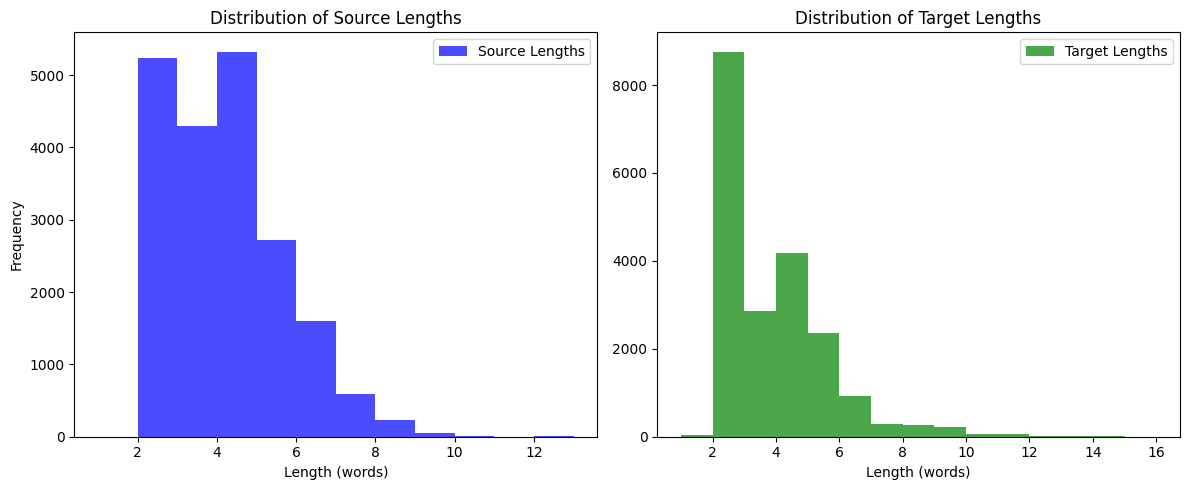

In [13]:
df_train = refind_datasets['train'].to_pandas()
# Apply the entity extraction and length calculation on the DataFrame
df_train['e1_length'], df_train['e2_length'] = zip(*df_train.apply(extract_entities, axis=1))
analyze_entity_lengths(df_train)

In [28]:
sample = refind_datasets['train'][59]
print(sample.keys())

dict_keys(['id', 'docid', 'relation', 'rel_group', 'token', 'e1_start', 'e1_end', 'e2_start', 'e2_end', 'e1_type', 'e2_type', 'spacy_pos', 'spacy_ner', 'spacy_head', 'spacy_deprel', 'sdp', 'sdp_tok_idx', 'token_test', 'e1', 'e2'])


In [32]:
print(sample['relation'],"\n",sample['rel_group'])

org:org:subsidiary_of 
 ORG-ORG


In [33]:
print(sample['token'],"\n",len(sample['token']))

['When', 'Granite', 'Falls', 'Energy', ',', 'LLC', 'use', 'the', 'terms', '"', 'Granite', 'Falls', 'Energy', '"', ',', '"', 'we', '"', ',', '"', 'us', '"', ',', '"', 'our', '"', ',', 'the', '"', 'Company', '"', ',', '"', 'GFE', '"', 'or', 'similar', 'words', 'in', 'this', 'Annual', 'Report', 'on', 'Form', '10', '-', 'K', ',', 'unless', 'the', 'context', 'otherwise', 'requires', ',', 'Granite', 'Falls', 'Energy', ',', 'LLC', 'are', 'referring', 'to', 'Granite', 'Falls', 'Energy', ',', 'LLC', 'and', 'its', 'wholly', 'owned', 'subsidiary', ',', 'Project', 'Viking', ',', 'L.L.C', ',', 'through', 'which', 'Granite', 'Falls', 'Energy', ',', 'LLC', 'hold', 'a', 'controlling', 'interest', 'in', 'Heron', 'Lake', 'BioEnergy', ',', 'LLC', '.'] 
 96


In [39]:
print(sample['e1'],"\n",sample['e2'])

projectvikingllc 
 granitefallsenergyllc


In [37]:
print(sample['e1_start'],"\n",sample['e1_end'])

73 
 77


In [40]:
print(sample['token'][sample['e1_start']:sample['e1_end']],
      "\n",
     sample['token'][sample['e2_start']:sample['e2_end']])

['Project', 'Viking', ',', 'L.L.C'] 
 ['Granite', 'Falls', 'Energy', ',', 'LLC']


In [41]:
all_labels = set()
all_label_groups = set()
all_entity_types = set()

for item in tqdm(refind_datasets['train']):
    all_labels.add(item['relation'])
    all_label_groups.add(item['rel_group'])
    all_entity_types.add(item['e1_type'])
    all_entity_types.add(item['e2_type'])

print(len(all_label_groups), len(all_labels), len(all_entity_types))

100%|███████████████████████████████████| 20070/20070 [00:09<00:00, 2144.84it/s]

8 22 8


In [42]:
print(all_label_groups)

{'ORG-DATE', 'ORG-ORG', 'PERSON-TITLE', 'PERSON-GOV_AGY', 'PERSON-UNIV', 'ORG-GPE', 'PERSON-ORG', 'ORG-MONEY'}


In [43]:
print(all_entity_types)

{'MONEY', 'TITLE', 'PERSON', 'ORG', 'UNIV', 'DATE', 'GOV_AGY', 'GPE'}


In [44]:
print(all_labels)

{'pers:gov_agy:member_of', 'pers:title:title', 'org:org:shares_of', 'org:gpe:headquartered_in', 'pers:org:member_of', 'org:org:acquired_by', 'pers:univ:attended', 'org:gpe:operations_in', 'pers:univ:employee_of', 'pers:org:founder_of', 'pers:org:employee_of', 'org:money:cost_of', 'org:org:subsidiary_of', 'org:money:revenue_of', 'org:money:profit_of', 'no_relation', 'pers:univ:member_of', 'org:date:formed_on', 'org:gpe:formed_in', 'org:money:loss_of', 'org:org:agreement_with', 'org:date:acquired_on'}


In [49]:
e1 = ' '.join(sample['token'][sample['e1_start']: sample['e1_end']])
e2 = ' '.join(sample['token'][sample['e2_start']: sample['e2_end']])

text = ' '.join(sample['token']) + "\n E1 : {}".format(e1) + '\n E2 : {}'.format(e2)
print(text)

When Granite Falls Energy , LLC use the terms " Granite Falls Energy " , " we " , " us " , " our " , the " Company " , " GFE " or similar words in this Annual Report on Form 10 - K , unless the context otherwise requires , Granite Falls Energy , LLC are referring to Granite Falls Energy , LLC and its wholly owned subsidiary , Project Viking , L.L.C , through which Granite Falls Energy , LLC hold a controlling interest in Heron Lake BioEnergy , LLC .
 E1 : Project Viking , L.L.C
 E2 : Granite Falls Energy , LLC
